# **G2Net Gravitational Wave Detection**

### **Setup**
Importing necessary modules

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random
from colorama import Fore, Back, Style

plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

Loading the data

In [2]:
labels = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")

print(Fore.BLUE + "Dataset has ",Style.RESET_ALL + "{} Observations".format(labels.shape[0]))

print(Fore.GREEN + "First 5 Observations:",Style.RESET_ALL)
display(labels.head())

Dataset has  560000 Observations
First 5 Observations: 


,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [3]:
# build a training dataframe for all the available .npy files along with their path

# path of the files
paths = glob("../input/g2net-gravitational-wave-detection/train/*/*/*/*")

# list of ids of .npy files 
ids = [path.split("/")[-1].split(".")[0] for path in paths]

# data frame containing paths and ids of .npy files 
path_df = pd.DataFrame({"path":paths,"id":ids})

# merge the dataframe built above with the dataset having target
train_df = pd.merge(left=labels,right=path_df,on="id")

# this would a comprehensive df which would include "id","target" and "path" for each of the .npy file in train folder
display(train_df.head())

# lets confirm whether the dataframe built above has expected no. of rows(560000)
print(Fore.BLUE + "No.of rows in the merged dataframe:",train_df.shape[0],Style.RESET_ALL)

,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...


No.of rows in the merged dataframe: 560000 


In [4]:
# segregate dataframes for individual classes
target_1 = train_df[train_df.target==1]
target_0 = train_df[train_df.target==0]

### **Class Distribution**

Both the labels (target=0, target=1) have equal distribution in dataset

In [5]:
print("Class Distribution:\n",labels.target.value_counts())

Class Distribution:
 0    280070
1    279930
Name: target, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

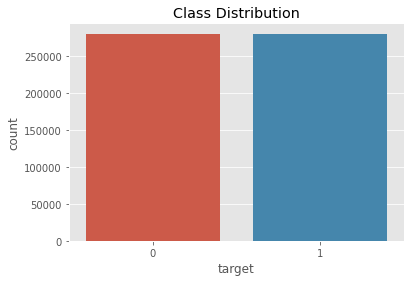

In [6]:
# visualize class distribution
sns.countplot(x="target", data=labels)
plt.title("Class Distribution")

### **Data Analysis**

SITE-1, SITE-2 & SITE-3 are 3 different serieses

In [7]:
# visualize the randomly selected series
def plot_series(series,plot,target):
    if plot == "box" or plot == "kde":
        plt.figure(figsize = (20,2))    
    else:
        plt.figure(figsize = (15,12))    
    
    for idx in range(3):
        if plot == "box":
            plt.subplot(1,3,idx+1)            
            sns.boxplot(series[idx:idx+1],color = 'b')  
            
        elif plot == "kde":
            plt.subplot(1,3,idx+1)            
            sns.kdeplot(series[idx],color = 'r', shade=True,lw=2, alpha=0.5)
        else:
            plt.subplot(3,1,idx+1)            
            plt.plot(series[idx:idx+1].T,color = 'g')
            plt.title("\nSite-" + str(idx+1))        
            
    if plot == "box":    
        plt.suptitle("Box Plots(target = " + target + ")")
    elif plot == "kde":    
        plt.suptitle("Probablity Distribution Plots(target = " + target + ")")
    else:    
        plt.suptitle("Time Distribution of Signals - Spans 2 sec, Sampled at 2,048 Hz(target = " + target + ")")

        
    plt.show()

Shape of the selected signal: (3, 4096) 





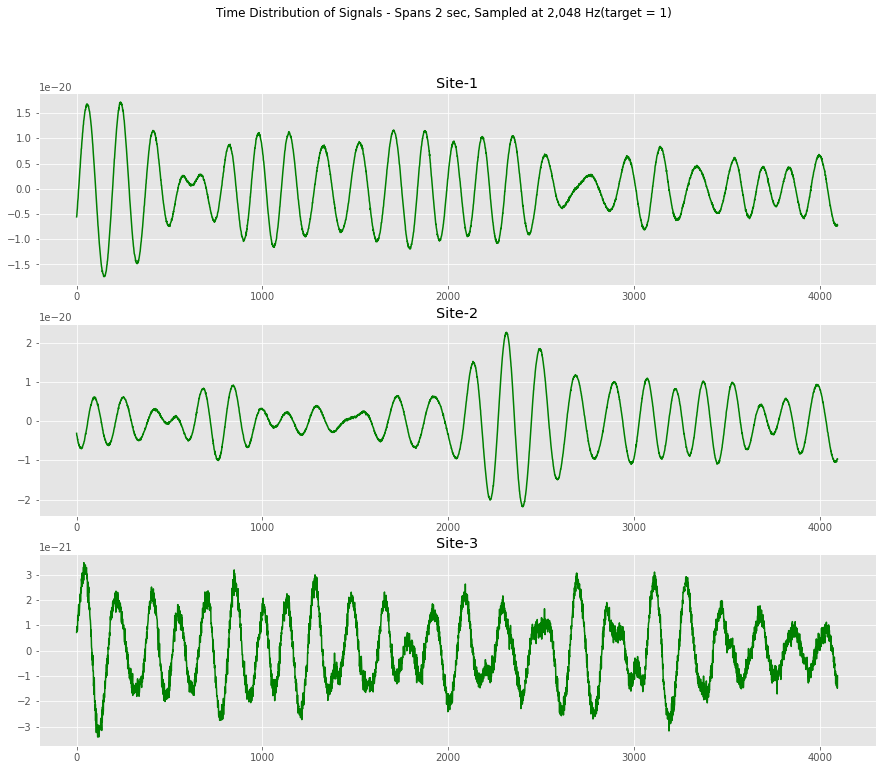

In [8]:
# pick a random series(target=1)
target_1 = target_1.sample(1).path.values[0]

pos = np.load(target_1)

print(Fore.BLUE + "Shape of the selected signal:",pos.shape,Style.RESET_ALL)
print("\n\n")

plot_series(pos,"time","1")

Shape of the selected signal: (3, 4096) 





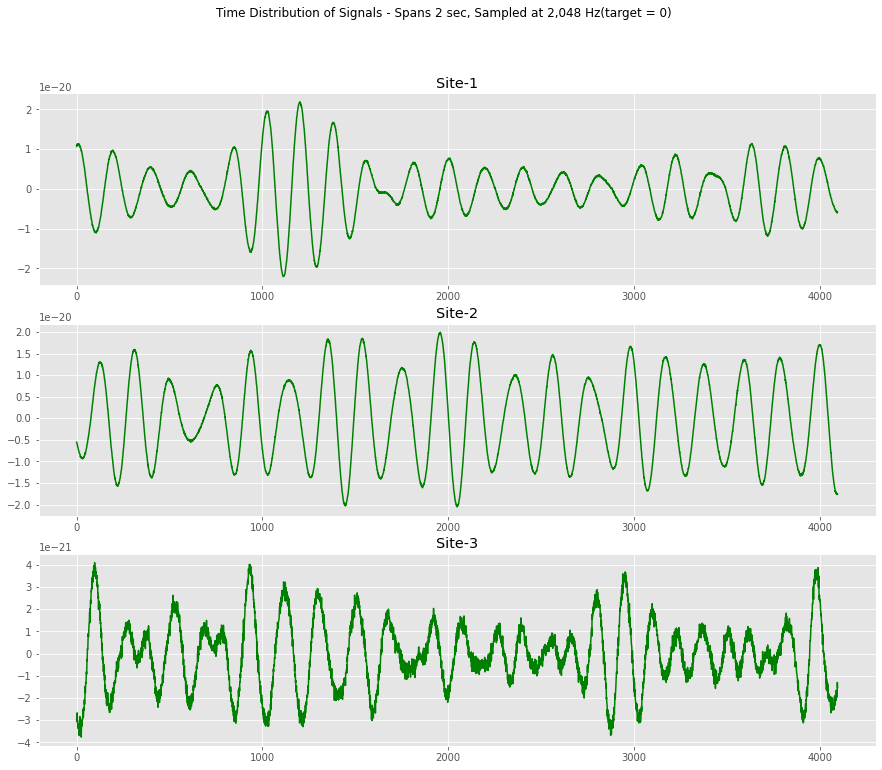

In [9]:
# pick a random series(target=1)
target_0 = target_0.sample(1).path.values[0]

neg = np.load(target_0)
print(Fore.BLUE + "Shape of the selected signal:",neg.shape,Style.RESET_ALL)
print("\n\n")

plot_series(neg,"plot","0")

We have a huge time series of approximately 560,000 files each of which has dimensions of 3 * 4096.

The series with no signals have bigger fluctuations, whereas the series with signal absent have smaller and more consistent fluctuations.

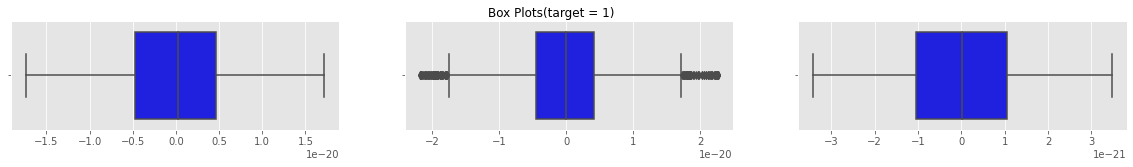

In [10]:
# Probability Distribution plots for target == 1 (Signal is missing)
plot_series(pos,"box","1")

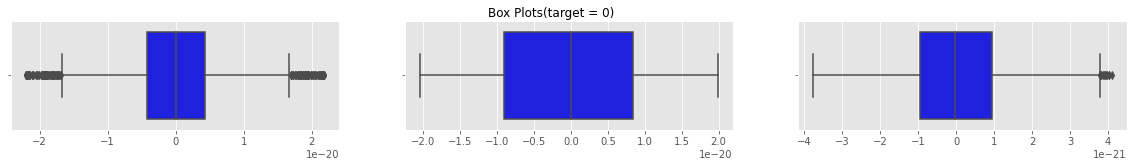

In [11]:
# Probability Distribution plots for target == 0 (Signal is missing)
plot_series(neg,"box","0")

These 3 sites ahve fairly similar distribution for both class types.

Third site seems to have difference in outliers which is the only visible difference.

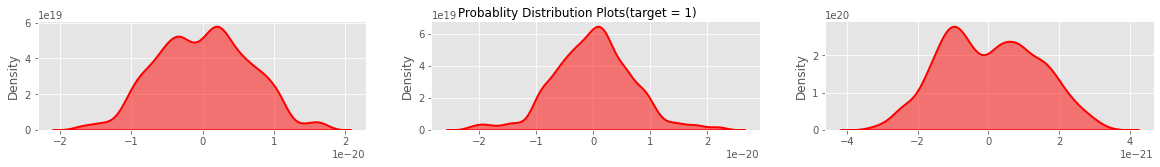

In [12]:
# Probability Distribution plots for target == 1 (Signal is present)
plot_series(pos,"kde","1")

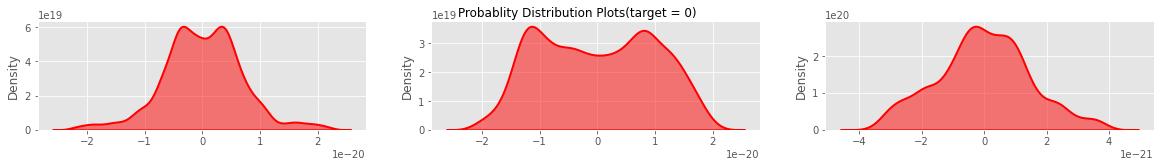

In [13]:
# Probability Distribution plots for target == 0 (Signal is missing)
plot_series(neg,"kde","0")

KDE plots for both classes looks almost similar for SITE-3; SITE-2  has little bit more variation for target=0 whereas SITE-1 has more variation for target=1.

In [14]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam

import warnings
warnings.filterwarnings("ignore")

### **Data Generator**

To feed real-time data to Keras Model.

In [15]:
class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, data, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))
        
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, 3, 4096))
        y = np.zeros((self.batch_size, 1))
        for i, ID in enumerate(list_IDs_temp):
            id_ = self.data.loc[ID, 'id']
            file = id_+'.npy'
            path_in = '/'.join([self.path, id_[0], id_[1], id_[2]])+'/'
            data_array = np.load(path_in+file)
            data_array = (data_array-data_array.mean())/data_array.std()
            X[i, ] = data_array
            y[i, ] = self.data.loc[ID, 'target']
        return X, y

In [16]:
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
train_idx =  labels['id'].values
y = labels['target'].values
test_idx = sample_submission['id'].values

In [17]:
train_idx, train_Valx = train_test_split(list(labels.index), test_size=0.33, random_state=2021)
test_idx = list(sample_submission.index)

In [18]:
train_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/train/', train_idx, labels, 64)
val_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/train/', train_Valx, labels, 64)
test_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/test/', test_idx, sample_submission, 64)

In [19]:
model = Sequential()
model.add(Conv1D(64, input_shape=(3, 4096,), kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2022-07-26 04:18:51.930178: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
model.compile(optimizer = Adam(lr=2e-4),loss='binary_crossentropy',metrics=['acc'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             786496    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 790,977
Trainable params: 790,849
Non-trainable params: 128
_________________________________________________________________


In [22]:
history = model.fit_generator(generator=train_generator, validation_data=val_generator, epochs = 1, workers=4)

2022-07-26 04:18:52.755707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


5863/5863 [==============================] - 1217s 207ms/step - loss: 0.7005 - acc: 0.4994 - val_loss: 0.6961 - val_acc: 0.5016


In [23]:
predict = model.predict_generator(test_generator, verbose=1)

3532/3532 [==============================] - 2062s 584ms/step


In [24]:
sample_submission['target'] = predict[:len(sample_submission)]

In [25]:
sample_submission.to_csv('submission.csv', index=False)

In [26]:
my_submission = pd.read_csv("./submission.csv")
my_submission

,id,target
0,00005bced6,0.475480
1,0000806717,0.578184
2,0000ef4fe1,0.405668
3,00020de251,0.553027
4,00024887b5,0.461288
...,...,...
225995,ffff4125f1,0.510806
225996,ffff9d32a6,0.522398
225997,ffff9f4c1f,0.536030
225998,ffffa19693,0.454845
